# Imports, Paths and Data

In [1]:
from fastai.groups.default_cnn import *
import pixiedust
import shutil

Pixiedust database opened successfully


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
PATH = '/data/msnow/nih_cxr/'

In [5]:
!ls {PATH}

BBox_List_2017.csv   Data_Entry_2017.csv~  targz  tst
Data_Entry_2017.csv  images		   trn


# Basic Exploration

In [7]:
!wc -l {PATH}Data_Entry_2017.csv

112121 /data/msnow/nih_cxr/Data_Entry_2017.csv


In [5]:
label_csv = f'{PATH}Data_Entry_2017.csv'
data_entry = pd.read_csv(label_csv,dtype=str)
data_entry.head()

,image,labels,followup,id,age,gender,view,image_width,image_height,pixelspacing_x,pixelspacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [6]:
train_list = pd.read_table(f'{PATH}train_val_list.txt', header=None)
test_list = pd.read_table(f'{PATH}test_list.txt', header=None)
data_entry.shape,train_list.shape, test_list.shape

((112120, 11), (86524, 1), (25596, 1))

In [7]:
data_entry['train'] = 0
data_entry.loc[data_entry.image.isin(train_list[0]),'train']=1

In [8]:
data_entry.head()

,image,labels,followup,id,age,gender,view,image_width,image_height,pixelspacing_x,pixelspacing_y,train
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,1
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,1
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,0


## Split the images into testing and training folders

In [144]:
src = os.path.join(PATH,'images')
dst = os.path.join(PATH,'trn')
img_list = data_entry.loc[data_entry.train==1,'image'].tolist()
for img in img_list:
    src_img = os.path.join(src,img)
    dst_img = os.path.join(dst,img)
    shutil.copyfile(src_img,dst_img)

In [145]:
src = os.path.join(PATH,'images')
dst = os.path.join(PATH,'tst')
img_list = data_entry.loc[data_entry.train==0,'image'].tolist()
for img in img_list:
    src_img = os.path.join(src,img)
    dst_img = os.path.join(dst,img)
    shutil.copyfile(src_img,dst_img)

In [148]:
files

['00000001_000.png',
 '00000001_001.png',
 '00000001_002.png',
 '00000002_000.png',
 '00000004_000.png']

In [147]:
files = os.listdir(f'{PATH}trn')[:5]
files

['00000001_000.png',
 '00000001_001.png',
 '00000001_002.png',
 '00000002_000.png',
 '00000004_000.png']

In [13]:
??plt

(1024, 1024)
0.0 1.0


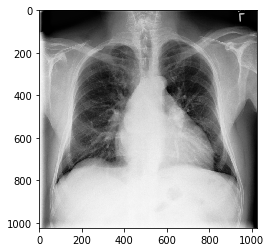

In [15]:
img = plt.imread(f'{PATH}trn/{files[0]}')
plt.imshow(1-img,cmap='Greys');
print(img.shape)
print(np.min(img),np.max(img))

# Using pre-trained model

Create the splits for training, validation and testing.  Splitting based on patients, not images

In [9]:
data_trn = data_entry.loc[data_entry.train==1,:]
data_trn = data_trn.iloc[:,:-1].reset_index(drop=True)
data_tst = data_entry.loc[data_entry.train==0,:]
data_tst = data_tst.iloc[:,:-1].reset_index(drop=True)
data_trn.shape, data_trn.id.nunique(), data_tst.shape, data_tst.id.nunique()

((86524, 11), 28008, (25596, 11), 2797)

Make sure that there are no patients who have images in both the testing and training set

In [271]:
data_trn_id = set(data_trn.id.tolist())
data_tst_id = set(data_tst.id.tolist())
len(list(data_trn_id & data_tst_id))

0

In [304]:
data_trn.to_csv(f'{PATH}data_trn.csv',index=False)

In [264]:
data_trn.id.min(),data_trn.id.max(), data_trn.id.nunique()

('1', '9999', 28008)

In [10]:
id_to_idx = {v:i for i,v in enumerate(data_trn.id.unique())}
idx_to_id = {i:v for i,v in enumerate(data_trn.id.unique())}

Extract the indices for the validation set based on the patient id's

In [11]:
val_id_idx = np.random.RandomState(42).choice(range(len(idx_to_id)),int(0.2*len(idx_to_id)),replace=False)
trn_id_idx = np.setdiff1d(range(len(idx_to_id)),val_id_idx)
trn_id_idx.shape, val_id_idx.shape

((22407,), (5601,))

In [12]:
val_id_list = [idx_to_id[x] for x in val_id_idx]
val_idx = data_trn.index[data_trn.id.isin(val_id_list)].tolist()
trn_id_list = [idx_to_id[x] for x in trn_id_idx]
trn_idx = data_trn.index[data_trn.id.isin(trn_id_list)].tolist()

## Initial Model Settings and Exploration

In [13]:
arch = resnet34
sz = 64
bs = 64

In [14]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_basic, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'trn', f'{PATH}data_trn.csv', tfms=tfms,
                    val_idxs=val_idx, test_name='tst', bs=bs, cat_separator='|')
data = get_data(sz,bs)

In [49]:
learn = ConvLearner.pretrained(arch, data)

In [55]:
learn.crit

<function torch.nn.functional.binary_cross_entropy(input, target, weight=None, size_average=True, reduce=True)>

In [ ]:
%%pixie_debugger
learn2 = ConvLearner.pretrained(arch, data, custom_head=nn.Sequential(*learn.models.get_fc_layers()))



In [82]:
sz = 128

In [83]:
data_o = get_data(sz,bs)

In [84]:
data = data_o.resize(int(sz*1.3), 'tmp')

In [325]:
x,y = next(iter(data.val_dl))

In [326]:
y.shape

torch.Size([64, 15])

In [327]:
list(zip(data.classes, y[0]))

[('Atelectasis', tensor(0.)),
 ('Cardiomegaly', tensor(0.)),
 ('Consolidation', tensor(0.)),
 ('Edema', tensor(0.)),
 ('Effusion', tensor(0.)),
 ('Emphysema', tensor(0.)),
 ('Fibrosis', tensor(0.)),
 ('Hernia', tensor(0.)),
 ('Infiltration', tensor(0.)),
 ('Mass', tensor(0.)),
 ('No Finding', tensor(1.)),
 ('Nodule', tensor(0.)),
 ('Pleural_Thickening', tensor(0.)),
 ('Pneumonia', tensor(0.)),
 ('Pneumothorax', tensor(0.))]

In [328]:
x.shape

torch.Size([64, 3, 64, 64])

In [329]:
data.val_ds.denorm(to_np(x)).shape

(64, 64, 64, 3)

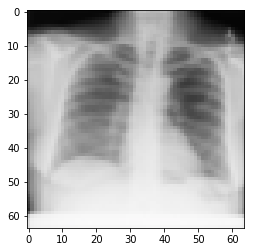

In [330]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]);

In order to not have to resize images which are very large for each batch which takes a lot of time, you can just resize all the images once using the resize() method. This creates a new set of images based on the original images matched o whatever size you specify.

In [331]:
learn = ConvLearner.pretrained(arch, data)

In [102]:
lrf=learn.lr_find()
learn.sched.plot()

33655

In [332]:
lr = 2e-2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                      
    0      0.199008   0.18701    0.935444  
    1      0.194243   0.183975   0.935882                      
 43%|████▎     | 472/1088 [52:22<1:08:20,  6.66s/it, loss=0.191]

KeyboardInterrupt: 

In [149]:
lrs = np.array([lr/9,lr/3,lr])

<function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>

In [85]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)